<a href="https://colab.research.google.com/github/augnoel/noel/blob/develop/standardA_clustering_prac7_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##0. 패키지 호출

In [ ]:
#설치
!pip install konlpy
#한글 데이터 다룰ㄸ 사용할 토큰 라이브러리

In [2]:
#클러스터링 분석에 사용할 기본 패키지 호출
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [3]:
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [4]:
#warning 메시지 무시를 위한 코드
import warnings
warnings.filterwarnings('ignore')

In [5]:
#Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##1. 영화 댓글 클러스터링
###1.1. 데이터 전처리

In [8]:
#데이터셋 출처 - https://www.kaggle.com/datasets/ehddnr301/naver-review
df_review = pd.read_csv("/content/drive/MyDrive/ratings.txt", delimiter = "\t")
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        200000 non-null  int64 
 1   document  199992 non-null  object
 2   label     200000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


In [ ]:
df_review.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


### 1.1 데이터 전처리

In [ ]:
#결측치 제거
df_review = df_review.dropna()
#비어있는 다큐먼트 제거

#데이터 양이 많으므로 일부만 사용
df_review = df_review.sample(n=1000, random_state=9)
# drop은 False가 기본값,
# 불필요한 칼럼 다 날림
df_review = df_review.reset_index(drop=True)
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        1000 non-null   int64 
 1   document  1000 non-null   object
 2   label     1000 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 23.6+ KB


In [9]:
df_review.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [10]:
#OpenKoreanText 토크나이저 사용해서 문장 쪼개기
okt = Okt()
sample_review = df_review['document'][1]

print(sample_review)
# 형태소 단위로 쪼개기
print(okt.morphs(sample_review))
# nouns를 통해 명사만 가져오겠다
print(okt.nouns(sample_review))
print(okt.pos(sample_review))
# 문장을 형태소 분석을 하되, 품사만 사용,

디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부러웠는데. 사실 우리나라에서도 그 어려운시절에 끝까지 열정을 지킨 노라노 같은 전통이있어 저와 같은 사람들이 꿈을 꾸고 이뤄나갈 수 있다는 것에 감사합니다.
['디자인', '을', '배우는', '학생', '으로', ',', '외국', '디자이너', '와', '그', '들', '이', '일군', '전통', '을', '통해', '발전', '해가는', '문화', '산업', '이', '부러웠는데', '.', '사실', '우리나라', '에서도', '그', '어려운', '시절', '에', '끝', '까지', '열정', '을', '지킨', '노라노', '같은', '전통', '이', '있어', '저', '와', '같은', '사람', '들', '이', '꿈', '을', '꾸고', '이뤄', '나갈', '수', '있다는', '것', '에', '감사합니다', '.']
['디자인', '학생', '외국', '디자이너', '그', '일군', '전통', '통해', '발전', '문화', '산업', '사실', '우리나라', '그', '시절', '끝', '열정', '노라노', '전통', '저', '사람', '꿈', '수', '것']
[('디자인', 'Noun'), ('을', 'Josa'), ('배우는', 'Verb'), ('학생', 'Noun'), ('으로', 'Josa'), (',', 'Punctuation'), ('외국', 'Noun'), ('디자이너', 'Noun'), ('와', 'Josa'), ('그', 'Noun'), ('들', 'Suffix'), ('이', 'Josa'), ('일군', 'Noun'), ('전통', 'Noun'), ('을', 'Josa'), ('통해', 'Noun'), ('발전', 'Noun'), ('해가는', 'Verb'), ('문화', 'Noun'), ('산업', 'Noun'), ('이', 'Josa'), ('부러웠는데', 'Adjective'), ('.', 'Punctuat

In [12]:
#token 중 일부 품사만 사용
pos_set = ['Noun', 'Verb', 'Alpha']

def selected_tokenizer(sent, pos = pos_set) :
    t = Okt()
    return [x[0] for x in t.pos(sent) if len(x[0]) > 1 and x[1] in pos]
#
df_review['tokens'] = df_review['document'].apply(selected_tokenizer)

AssertionError: phrase input should be string, not <class 'float'>

In [13]:
df_review.head()
# 문장에 단어, 품사 단위로 쪼갬
# ㅋㅋㅋ같은 것들ㅇ느 제거해함

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [14]:
#tokenization 이후 token 개수가 3개 미만인 경우 제외
# 단어를 3개 이상인 것만 선택
df_review = df_review[df_review['tokens'].apply(lambda x: len(x) >= 3)].reset_index(drop = True)
df_review.shape

KeyError: 'tokens'

In [15]:
#TfidfVectorizer 사용하여 문서 임베딩 진행
def bow2tfidfvec(bow_series) :
    '''
    input : a Series of bow lists
    output : vectors
    '''
    # 띄어쓰기 단위로
    data_bow = bow_series.apply(lambda x : " ".join(x)).to_list()
    #tfvectorizer = CountVectorizer()
    # 문장이 아닌 스트링형태로 쪼개서 넣어야 함
    tfidfvectorizer = TfidfVectorizer()
    X = tfidfvectorizer.fit_transform(data_bow)
    features = tfidfvectorizer.get_feature_names_out()

    return X, features
    # x는 벡터 메트릭스
    # feature

In [16]:
tfidfvec, features_tfidf = bow2tfidfvec(df_review['tokens'])

KeyError: 'tokens'

In [17]:
#
print(type(tfidfvec))
print(tfidfvec.shape)
# 토큰하나가 차원이 됨

NameError: name 'tfidfvec' is not defined

In [19]:
print(type(tfidfvec[0]))

NameError: name 'tfidfvec' is not defined

In [18]:
print([0])

[0]


In [ ]:
print(features_tfidf[-5:])
# array 형태

['희망' '희생' '히히히' '힐링' '힙합']


In [ ]:
print(tfidfvec[0].indices)
print(tfidfvec[0].data)

[1960  824 1801 2218]
[0.63219716 0.61554049 0.23913977 0.40527623]


In [ ]:
kmeans = KMeans(n_clusters=7, max_iter=1000, random_state=9).fit(tfidfvec)
#클러스터 갯수 선택

In [ ]:
cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
for id, size in zip(cluster_ids, cluster_sizes):
  print("cluster {}\t{}".format(id, size))
  # 각 클러스터에 포함된 데이터 갯수

cluster 0	39
cluster 1	21
cluster 2	32
cluster 3	32
cluster 4	148
cluster 5	49
cluster 6	445


In [ ]:
def plot_tsne_2d(df, label):
  tsne = TSNE(n_components=2)

  df_tsne = pd.DataFrame(data = tsne.fit_transform(df), columns = ['col1', 'col2'])
  df_tsne["label"] = label
  g = sns.FacetGrid(df_tsne, hue="label", height = 8, margin_titles = True,
                  palette = sns.color_palette())
  g.map_dataframe(plt.scatter, "col1", "col2")
  g.add_legend()
  g.fig.subplots_adjust(top=0.9)
  g.fig.suptitle("t-sne")
  g.set_xlabels("X")
  g.set_ylabels("Y")

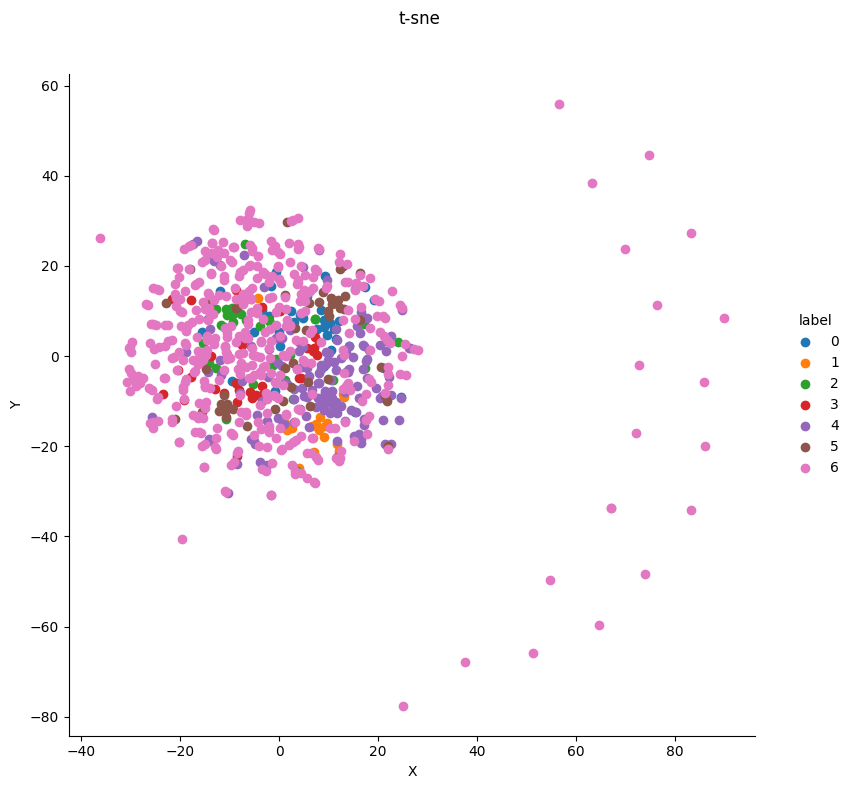

In [ ]:
df_tfvec = pd.DataFrame(tfidfvec.todense())
plot_tsne_2d(df_tfvec, kmeans.labels_)
# 데이터가 모여있음 >> 차원이 클수록 구형태가 나옴
# 텍스트 데이터 클러스터링을 할 때는 그래프보다는 키워드를 뽑아보거나, 제일 많은 단어가 뭔지 등을 뽑아보고 판단
# 문서간 거리 확인하는 코사인 거리나, 자카드 거리를 이용해 유사도 비교


In [ ]:
from sklearn.neighbors import NearestNeighbors
# 센터로이드의 주변 값을 찍어보기
# tfidfvec벡터 활용 - 모델학습에 그대로 사용할 수 있음

neighbors = NearestNeighbors(n_neighbors=20).fit(tfidfvec) #Centroid 주변 10개 이웃점 뽑기
distances, indices = neighbors.kneighbors(kmeans.cluster_centers_)
# 클러스터 센터 주변에 가까운 이웃 좌표 찍어봄


In [ ]:
# 4,5, 6, 클러스터에 대해 근처 데이터 차장보기
for i in [4, 5, 6]:
  # 4, 5,6 클러스터만 인다이스 값 가져옴

  review_idx_list = indices[i]
  print("cluster {}".format(i))
  for idx in review_idx_list:
    print("{} - {}".format(idx, df_review['document'][idx]))
  print()
  # 난해하게 묶여 있음
  # 단어가 모여 문장이 되는데 비슷한 단어가 있으면, 유사도에 의해 뽑히는데 이건 알기 힘듬
  # 2800개 차원을 코사이거리를 이용한 클러스털링을 하면 더 나아질지도?

cluster 4
569 - 최고의 영화 좋은 영화이다
688 - 잔잔한 영화지만 진지하게 빠져들수 있는 영화
394 - 뭐 이런영화가 다 있어... 하고 영화평점 사이트를 오게 온 영화.
432 - 극장에서 처음으로 본영화 쓰레기영화
529 - 우주영화 최고의영화
700 - 제작비가 정말로 아까운 영화.쓰레기 영화라는게 이런거구나..깨닫게 해준다.1점도 아까운 영화임.
453 - 이성 관계에 대한 영화중에 괜찮은 영화
391 - 끝부분만 좋았더라면.. 내가 본 영화 중 제일 어이없던 영화>_신고
407 - 평점 조절위원회...그냥 5점짜리영화..아주 과대평가된영화...뭔 이런영화가 8점대야...그냥 5점짜리 영화정도.
542 - 영화 스토리 흐름상 지루하지않고 일본영화는 정말 신기하다
563 - 최악, 1점도 아까운 영화
274 - 너무너무 사랑하는 영화....
658 - 영화 완전 재미없음...(책임집니다) 완전히 감동없는 영화, 하류감독작
10 - 생각하게하는영화 혼자보기좋은영화
452 - 이런 영화가 1점짜리영화다. 이해해볼려고 3번이나 봤지만 불쾌하기만 했다
252 - 딱 별 2개짜리 영화...이 정도 영화에 감동 받을 정도로 다들 감성이 풍부한건지...
194 - 10년전에 봣던 영화인데도 귀자르는 장면은 기억에 남아있는 영화
625 - 보고나서 일주일뒤면 영화 이름도 기억이 안나는 영화
484 - 미친영화..소름돋고 귀신아닌 로봇에 공포를 느끼고..진정한것이 무엇인지 생각해보게 되는 영화이면서 말로 표현할 수 없는 영화다
203 - 니콜의 연기만으로 보자면 10점만점을 주겠으나 영화를 보는 내내 스토리전개가 매우 답답하고 마지막의 여운이 뭘 말하고자 하는지도 모를 정도로 감독 지맘대로 만든 영화라는 느낌이 전부인 영화입니다. 굳이 극장까지 가기엔 모호한...

cluster 5
307 - 그냥 놀래키기만 할뿐 그냥 불쾌한 영화다
129 - 그냥 별 생각없이 보고나서 생각해보니 감탄사가 터지는 영화
759 - 이 영화 시리즈는 그냥 짱이다♥
336 

In [ ]:
!pip install soyclustering
# 코사인거리를 이용한 K-means

In [21]:
from soyclustering import SphericalKMeans

spherical_kmeans = SphericalKMeans(
    n_clusters=10,
    max_iter=100,
    verbose=1,
    init='similar_cut',
    random_state=9
)

In [22]:
s_labels = spherical_kmeans.fit_predict(tfidfvec)
# 넘파이 버전에 의해 에러날 것임

# dtype=np.int63로 바꿔서 저장

NameError: name 'tfidfvec' is not defined

In [ ]:
from collections import Counter
# 라벨값이 어떤 클러스터에 많은지 확인
# 0, 9, 1, 2, 순으로 많음
c = Counter()
c.update(s_labels)
c.most_common()

[(0, 288),
 (9, 174),
 (1, 85),
 (2, 44),
 (3, 42),
 (8, 42),
 (5, 42),
 (7, 21),
 (4, 17),
 (6, 11)]

In [ ]:
# 메트릭을 코사인으로 설정하여 거리 측정

neighbors2 = NearestNeighbors(n_neighbors=20, metric='cosine').fit(tfidfvec) #Centroid 주변 10개 이웃점 뽑기
# 센트로이드 데이터값
#
distances2, indices2 = neighbors2.kneighbors(spherical_kmeans.cluster_centers_)

In [ ]:
# 코사인 거리를 활용한 k-means 결과
# 센터로이드 주변 데이터 값

for i in [0, 9, 1, 2]:
  review_idx_list = indices2[i]
  print("cluster {}".format(i))
  for idx in review_idx_list:
    print("{} - {}".format(idx, df_review['document'][idx]))
  print()

  # 2번 클러스터에 마지막이라는 단어가 포함된 문자이 많이 나옴


cluster 0
336 - 그냥 c급 드라마 같은 느낌임
567 - 06년에 보고 09년에 다시 봐도 역시나 최고의 드라마다.
426 - 정말 감동도 있지만 재미도 있고 몰입도가 좋았던거 같은 작품
309 - 재미도 있고, 내용도 있고, 감동도 있고...
110 - 마지막 장면 때문에 10점
90 - 정말 가슴따뜻해지는 힐링드라마..매주 감동의 눈물과함께 재밌게 보고있습니다.. 부디 오래 오래 방영해주세요^^
190 - 12년 전 드라마인데 정말 완벽하다. 스토리며 연기력이며 흥미도며 몰입도며
272 - tvn드라마중에서최고
643 - 최고 이 말 외엔 뭐가 어울릴지...ㅠ시즌3마지막 너무 감동적이예요
605 - 마지막편 엔딩 정말 잊혀지지 않는다.
133 - 이 드라마 제작의 목적이...?어이 없는 시나리오때문에 명연기자들의 연기가 오히려 보이지 않네요.이런식으로의 후속작은 나오지 않았으면 좋겠습니다.드라마 마지막회 보고 기분이 참 좋지 않네요..
413 - 가족을 되돌아 보게 하는 드라마네요~~간만에 가슴 찡한 드라마 봅니다
633 - 정말 많은 생각을 하게 만드는 영화예요. 정말좋네요
172 - 인간적이면서 감동입니다!!!!~정말 재밌어요!!
624 - 내용은 교육적이나 정말지루해서요ㅜ
149 - ost도 너무좋고 마지막으로 갈 즈음 좀 아쉬운 부분도 있었지만 오래 기억 될 드라마!! 배우들의 명연기도 정말 좋았습니당
74 - 박영규랑선우선 볼때마다 역겨움ㅡㅡ드라마가 완전막장이얔ㅋㅋ 작가수준하고는ㅉㅉ엠비씨도 참 드라마 못고르넼ㅋㅋ거지같은드라마ㅡㅡ
290 - 막장드라마 난무하는 요즘 보석같이 귀한 드라마... 주인공들간의 얼키는 설정 눈감아 주게 되는 공감가는 드라마임!
338 - 긴장도 없고 재미도 없고 내용도 없다
332 - 제가 이런 장르를 싫어해서 그런가요?? 별로 재미도없고 그냥그렇네요

cluster 9
569 - 최고의 영화 좋은 영화이다
688 - 잔잔한 영화지만 진지하게 빠져들수 있는 영화
394 - 뭐 이런영화가 다 있어... 하고 영화

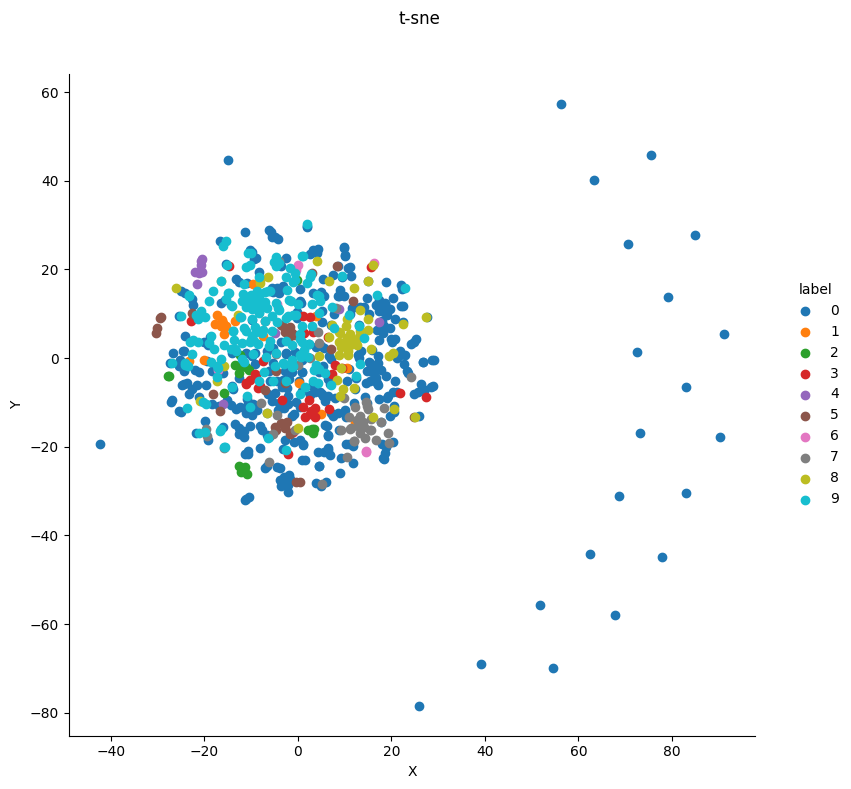

In [ ]:
plot_tsne_2d(df_tfvec, s_labels)